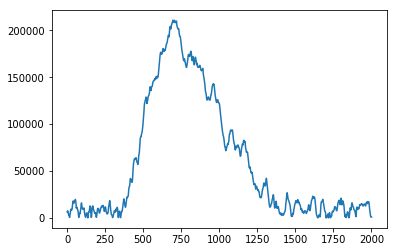

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import QPP_Funcs as qpp
import celerite as ce
import corner


log_params = [21.54616203, -1.41412777, -2.55327422, 14.8396898, 8.31950675, 4.8356601]

N = 1000
t = np.linspace(1,2001, N)
truemodel = qpp.CTSModel_prior(log_A = log_params[3], log_tau1 = log_params[4], log_tau2 = log_params[5])
truekernel = qpp.SHOTerm_Prior(log_S0 = log_params[0], log_Q = log_params[1], log_omega0 = log_params[2])
I = qpp.simulate(t, truemodel, truekernel, noisy=True)
plt.plot(t,I)
plt.show()


In [11]:
A_guess, t1_guess, t2_guess = qpp.initguess(t,I)
Ierr=np.sqrt(I)
model = qpp.CTSModel_prior(log_A = np.log(A_guess), log_tau1 = np.log(t1_guess), log_tau2 = np.log(t2_guess))
kernel = qpp.SHOTerm_Prior(log_S0 = np.log(1e8), log_Q = np.log(1e2), log_omega0 = np.log(0.07)) #write guesser for kernel parameters
gp = ce.GP(kernel, mean=model, fit_mean=True)
gp.compute(t, Ierr)

In [12]:
soln = qpp.optimize_gp(gp, I)

Initial log-likelihood: -48268.7068367
Final log-likelihood: -8694.97327033
Optimized log-parameters: [ 29.31846677  -2.98403792  -4.14876009  12.25779597   6.56535689
   7.14704774]


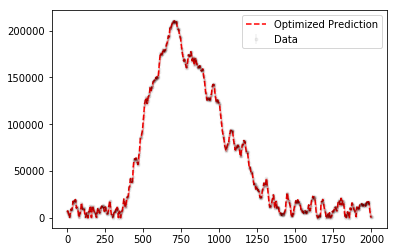

In [13]:
fig = qpp.plot_gp(t, I, Ierr, gp, model, soln=soln)
plt.show()

In [14]:
sampler = qpp.sample_gp(soln.x, I, gp, nsteps = 1500)

Burning in...
Sampling...


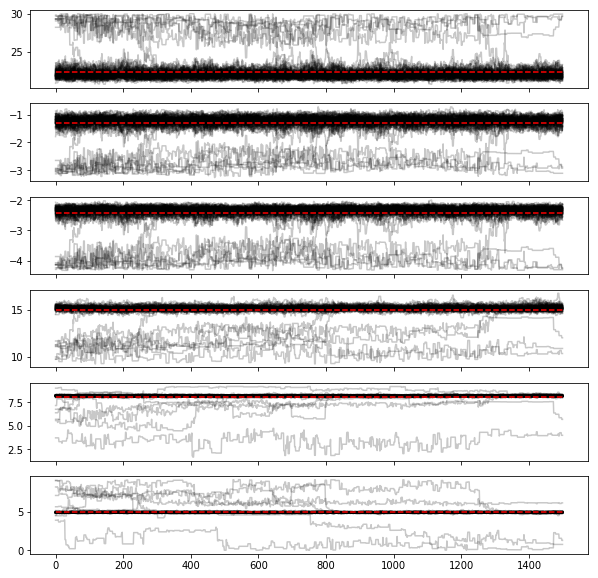

In [15]:
chain = sampler.chain
fig = qpp.plot_chain(chain)
plt.show()

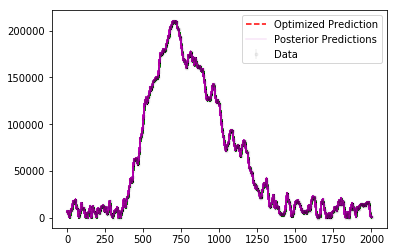

In [16]:
fig = qpp.plot_gp(t, I, Ierr, gp, model, soln=soln, chain=chain)
plt.show()

[ 21.96374595  -1.19754653  -2.30081591  15.14870858   8.22239072
   4.88383773]


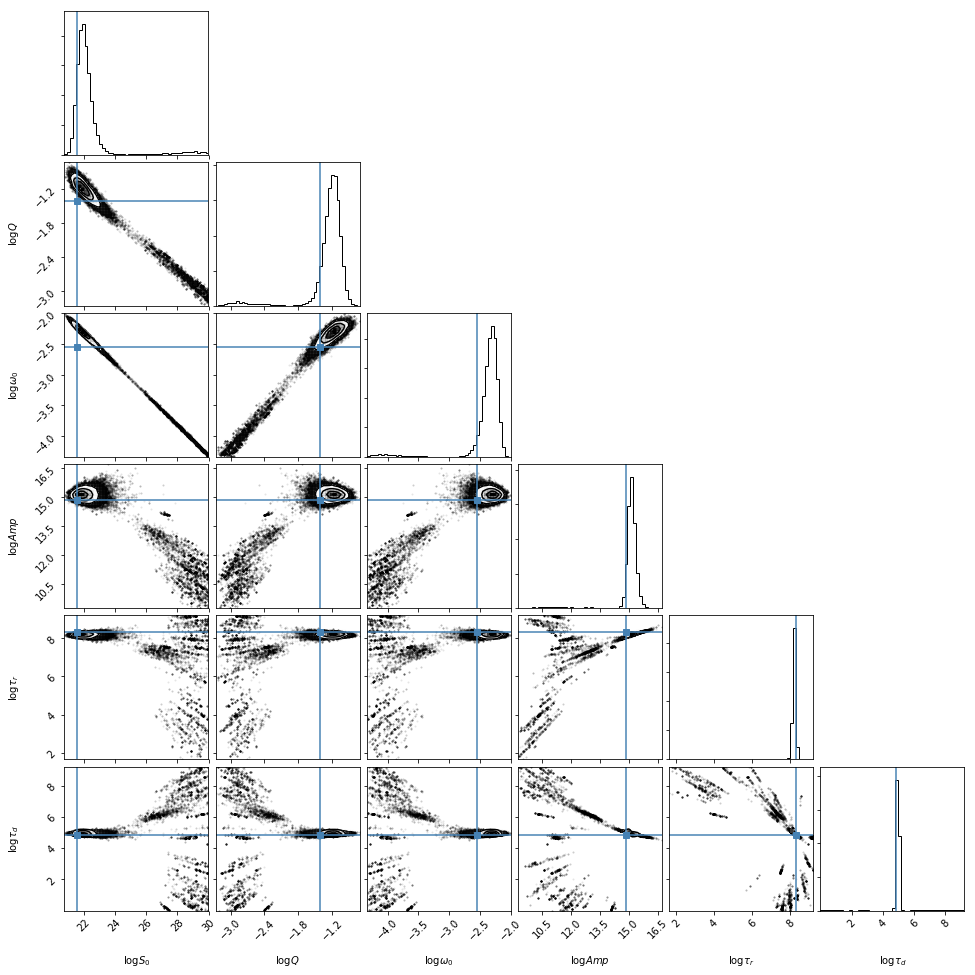

In [17]:
flat_samples = chain[:,200:, :].reshape((-1,6))

maxparams = np.empty(6)
for i in range(6):
    hist, bin_edges = np.histogram(flat_samples[:,i], bins = 50)
    maxindex = np.argmax(hist)

    maxparams[i] = np.average([bin_edges[maxindex], bin_edges[maxindex+1]])
    
fig = corner.corner(flat_samples, bins=50, labels = [r"$\log{S_0}$", r"$\log{Q}$", r"$\log{\omega_0}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = log_params,  range = [1,1,1,1,1,1])
plt.show()

In [18]:
print np.abs((np.exp(maxparams) - np.exp(log_params))/np.exp(log_params))


[ 0.51828881  0.24182397  0.28718583  0.36208795  0.09254929  0.04935703]


In [20]:
sampler.get_autocorr_time()

AutocorrError: The chain is too short to reliably estimate the autocorrelation time